# Install and Import Libraries

In [1]:
# Install Pytorch
!pip install -q segmentation_models_pytorch

# Importing Libraries
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import seaborn as sns
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd

# Libraries related to visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Libraries for validation and training from Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# Libraries from PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import segmentation_models_pytorch as smp
import timm

# Libraries related to Albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import rasterio
from joblib import Parallel, delayed

# Libraries for colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

# Libraries to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Library for error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Creating a function to set configurations for the notebook

In [2]:
class Config:
    seed          = 42
    debug         = False 
    model_name    = 'Unetr'
    train_bs      = 32
    valid_bs      = train_bs*2
    img_size      = (224, 224)
    epochs        = 20
    lr            = 2e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    fold_selected = 1
    num_classes   = 3
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
# We use set see for maintaining consistency in results. 
def set_seed(seed = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
set_seed(Config.seed)

> SEEDING DONE


In [4]:
# Reading the train.csv file 
df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/train.csv')
print(df.shape)

(115488, 3)


In [5]:
# Working with the dataframe. 
df.rename(columns = {'class':'class_name'}, inplace = True)

# Creating new columns called case, day and slice to store caseid, day9d, slideid
df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
df["slice"] = df["id"].apply(lambda x: x.split("_")[3])

# Extracting images from Train folder
TRAIN_DIR="../input/uw-madison-gi-tract-image-segmentation/train"
all_train_images = glob(os.path.join(TRAIN_DIR, "**", "*.png"), recursive=True)
x = all_train_images[0].rsplit("/", 4)[0] 

path_partial_list = []
for i in range(0, df.shape[0]):
    path_partial_list.append(os.path.join(x,
                          "case"+str(df["case"].values[i]),
                          "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                          "scans",
                          "slice_"+str(df["slice"].values[i])))
df["path_partial"] = path_partial_list

path_partial_list = []
for i in range(0, len(all_train_images)):
    path_partial_list.append(str(all_train_images[i].rsplit("_",4)[0]))
    
tmp_df = pd.DataFrame()
tmp_df['path_partial'] = path_partial_list
tmp_df['path'] = all_train_images

# Adding the path to images to the dataframe 
df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])

# Creating new columns height and width from the path details of images
df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))

# Deleting redundant columns
del x,path_partial_list,tmp_df

df.head(5)


,id,class_name,segmentation,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266


In [6]:
# Cleaning the dataframe
df_train = pd.DataFrame({'id':df['id'][::3]})

# Adding the segementations directly to the class object they belong to
df_train['large_bowel'] = df['segmentation'][::3].values
df_train['small_bowel'] = df['segmentation'][1::3].values
df_train['stomach'] = df['segmentation'][2::3].values

df_train['path'] = df['path'][::3].values
df_train['case'] = df['case'][::3].values
df_train['day'] = df['day'][::3].values
df_train['slice'] = df['slice'][::3].values
df_train['width'] = df['width'][::3].values
df_train['height'] = df['height'][::3].values

df_train.reset_index(inplace=True,drop=True)
df_train.fillna('',inplace=True); 
df_train['count'] = np.sum(df_train.iloc[:,1:4]!='',axis=1).values
df_train.sample(5)

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
28659,case36_day14_slice_0036,,,27047 6 27312 8 27578 8 27844 8 28109 9 28375 ...,../input/uw-madison-gi-tract-image-segmentatio...,36,14,0036,266,266,1
621,case77_day0_slice_0046,,,,../input/uw-madison-gi-tract-image-segmentatio...,77,0,0046,266,266,0
13728,case19_day18_slice_0081,17824 3 18182 7 18540 11 18899 20 19258 24 196...,30039 2 30397 7 30756 11 31116 15 31475 25 318...,,../input/uw-madison-gi-tract-image-segmentatio...,19,18,0081,360,310,2
24702,case108_day13_slice_0143,,,,../input/uw-madison-gi-tract-image-segmentatio...,108,13,0143,266,266,0
34099,case47_day27_slice_0068,33239 6 33597 10 33956 11 34314 14 34673 15 35...,26816 6 27175 8 27534 11 27893 13 28252 16 286...,,../input/uw-madison-gi-tract-image-segmentatio...,47,27,0068,360,310,2


# Performing Exploratory data analysis 

In [7]:
df_train['count'].value_counts().plot.bar()

##### There are a lot of images (~35000) who do not have a segmentation mask. 

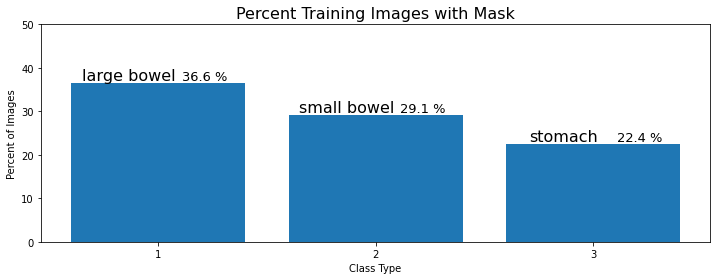

In [8]:
plt.figure(figsize=(12,4))
bar = plt.bar([1,2,3],100*np.mean( df_train.iloc[:,1:4]!='',axis=0))
plt.title('Percent Training Images with Mask', fontsize=16)
plt.ylabel('Percent of Images'); plt.xlabel('Class Type')
plt.xticks([1,2,3])
labels=["large bowel","small bowel","stomach"]
for rect,lbl in zip(bar,labels):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/3, height,  lbl,
             ha='center', va='bottom',fontsize=16)
    plt.text(rect.get_x() + rect.get_width()/1.3, height, '%.1f %%' % height,
             ha='center', va='bottom',fontsize=13)

plt.ylim((0,50)); plt.show()

# Using RLE encoded mask embedding from segemntation column and decoding the embeddings to visualize the masks on images.

In [9]:
def rle_decode(mask_rle, shape):
    '''mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction



def rle_encode(img):
    '''img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

#### Creating folds in order to execute Stratifiedkfold

In [10]:
# Creating samples
train_mask = list(df_train[df_train['large_bowel']!=''].index)
train_mask += list(df_train[df_train['small_bowel']!=''].index)
train_mask += list(df_train[df_train['stomach']!=''].index)

df_train=df_train[df_train.index.isin(train_mask)]     
df_train.reset_index(inplace=True,drop=True)
print(df_train.shape)

(16590, 11)


#### The Training data has 16590 rows and 11 columns

In [11]:
skf = StratifiedGroupKFold(n_splits=Config.n_fold, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=df_train, y=df_train['count'],groups =df_train['case']), 1):
    df_train.loc[val_idx, 'fold'] = fold
    
df_train['fold'] = df_train['fold'].astype(np.uint8)

train_ids = df_train[df_train["fold"]!=Config.fold_selected].index
valid_ids = df_train[df_train["fold"]==Config.fold_selected].index

df_train.groupby('fold').size()

fold
1    3973
2    2806
3    3656
4    3121
5    3034
dtype: int64

#### 5 folds were created with the associated number of instances in each row as displayed above

In [12]:
display(df_train.groupby(['fold','count'])['id'].count())

fold  count
1     1         556
      2        2664
      3         753
2     1         362
      2        1843
      3         601
3     1         607
      2        2348
      3         701
4     1         566
      2        2018
      3         537
5     1         377
      2        2048
      3         609
Name: id, dtype: int64

In [13]:
# Using a class for dataset which extracts the image and created masks on tho
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, subset="train", transforms=None):
        self.df = df
        self.subset = subset
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    
    def __getitem__(self, index): 
        masks = np.zeros((Config.img_size[0],Config.img_size[1], 3), dtype=np.float32)
        img_path=self.df['path'].iloc[index]
        w=self.df['width'].iloc[index]
        h=self.df['height'].iloc[index]
        img = self.__load_img(img_path)
        if self.subset == 'train':
            for k,j in zip([0,1,2],["large_bowel","small_bowel","stomach"]):
                rles=self.df[j].iloc[index]
                mask = rle_decode(rles, shape=(h, w, 1))
                mask = cv2.resize(mask, Config.img_size)
                masks[:,:,k] = mask
        
        masks = masks.transpose(2, 0, 1)
        img = img.transpose(2, 0, 1)

        if self.subset == 'train': return torch.tensor(img), torch.tensor(masks)
        else: return torch.tensor(img)
        
    def __load_gray_img(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        img = (img - img.min())/(img.max() - img.min())*255.0 
        img = cv2.resize(img, Config.img_size)
        img = np.expand_dims(img, axis=-1)
        img = img.astype(np.float32) / 255.
        return img
    def __load_img(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        img = (img - img.min())/(img.max() - img.min())*255.0 
        img = cv2.resize(img, Config.img_size)
        img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
        img = img.astype(np.float32) /255.
        return img
    



In [14]:
# Creating data augmentations for training and validation process
data_transforms = {
    "train": A.Compose([
        A.Resize(*Config.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.OneOf([
                A.RandomContrast(),
                A.RandomGamma(),
                A.RandomBrightness(),
                ], p=0.2),

        ], p=1.0),
    "valid": A.Compose([
        A.Resize(*Config.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

In [15]:
# Loading the dataset into two dataframes lates to be used for training and validating
train_dataset = BuildDataset(df_train[df_train.index.isin(train_ids)], transforms=data_transforms['train'])
valid_dataset = BuildDataset(df_train[df_train.index.isin(valid_ids)], transforms=data_transforms['valid'])

train_loader = DataLoader(train_dataset, batch_size=Config.train_bs, num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=Config.valid_bs,num_workers=4, shuffle=False, pin_memory=True)
    
# We get the imahe and mask size here
imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()

(torch.Size([32, 3, 224, 224]), torch.Size([32, 3, 224, 224]))

#### The image size is [32, 3, 224, 224]
#### The mask size is [32, 3, 224, 224]

####  Visualizing the masks from train dataset

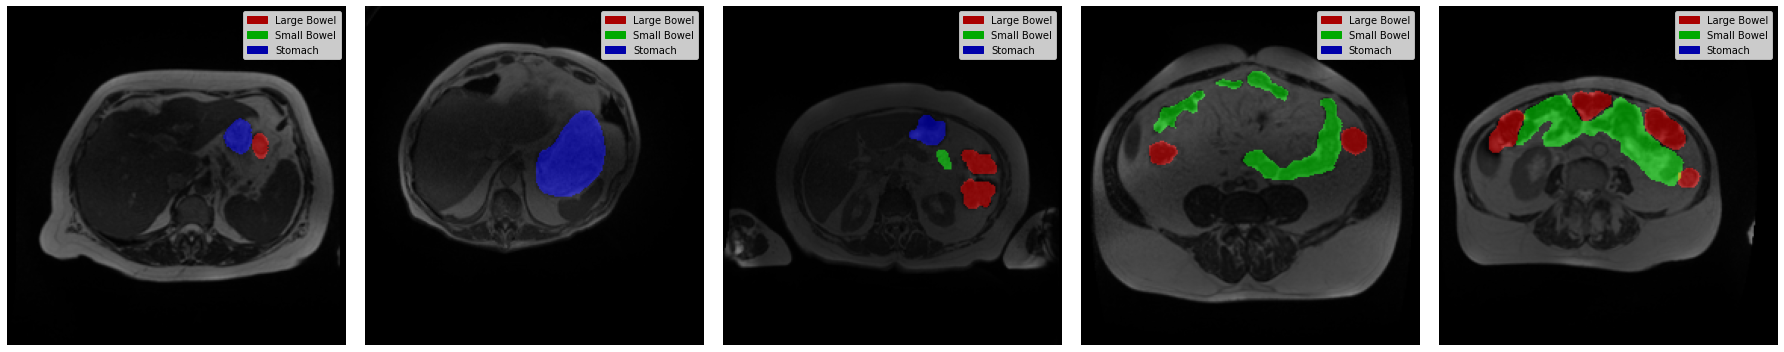

In [16]:
imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()

def plot_batch(imgs, msks, size=3):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()
        msk = msks[idx,].permute((1, 2, 0)).numpy()
        show_img(img, msk)
    plt.tight_layout()
    plt.show()

plot_batch(imgs, msks, size=5)

In [17]:
# If a process is idle, the garbage collector will not kick in.
# To release unused memory in idle time use gc.collect()
gc.collect()

18234

#### Creating the UNETr Model 


In [18]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
          )     
        
    def forward(self,x):
        return self.double_conv(x)

    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(2, 2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.encoder(x)

    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = DoubleConv(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x       

    
class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)


class UNetr(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 16 * n_channels)
        self.enc5 = Down(16 * n_channels, 16 * n_channels)
        
        self.dec1 = Up(32 * n_channels, 8 * n_channels)
        self.dec2 = Up(16 * n_channels, 4 * n_channels)
        self.dec3 = Up(8 * n_channels, 2 * n_channels)
        self.dec4 = Up(4 * n_channels, n_channels)
        self.dec5 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)
        x6 = self.enc5(x5)
        
        mask = self.dec1(x6, x5)
        mask = self.dec2(mask, x4)
        mask = self.dec3(mask, x3)
        mask = self.dec4(mask, x2)
        mask = self.dec5(mask, x1)
        mask = self.out(mask)
        return mask

In [19]:
# Creating functions for building and loading the models
def build_model():
    model = UNetr(in_channels=3, n_classes=3, n_channels=48)
    model.to(Config.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

#### We mainly focus on Dice and Jaccard loss

In [20]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return 0.6*BCELoss(y_pred, y_true) + 0.4*DiceLoss(y_pred, y_true)

In [21]:
#  Creating a function for Training the model
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion(y_pred, masks)
            loss   = loss / Config.n_accumulate
            
        scaler.scale(loss).backward()
    
        if (step + 1) % Config.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

        
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss

In [22]:
# Creating a function to perform validation
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

# Training the UNETr model

In [23]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients

    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=Config.device, epoch=epoch)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=Config.device, 
                                                 epoch=epoch)
        val_dice, val_jaccard = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)
        
        # Log the metrics

        
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        
        # deep copy the model
        if val_dice >= best_dice:
            print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_epoch   = epoch
            #run.summary["Best Dice"]    = best_dice
           # run.summary["Best Jaccard"] = best_jaccard
           # run.summary["Best Epoch"]   = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_epoch-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [24]:
def fetch_scheduler(optimizer):
    if Config.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=Config.T_max, 
                                                   eta_min=Config.min_lr)
    elif Config.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=Config.T_0, 
                                                             eta_min=Config.min_lr)
    elif Config.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=Config.min_lr,)
    elif Config.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif Config.scheduler == None:
        return None
        
    return scheduler

In [25]:
model = build_model()
optimizer = optim.Adam(model.parameters(), lr=Config.lr, weight_decay=Config.wd)
scheduler = fetch_scheduler(optimizer)

In [26]:
for fold in range(1):
    print(f'#'*35)
    print(f'######### Fold: {fold}')
    print(f'#'*35)
    model     = build_model()
    optimizer = optim.Adam(model.parameters(), lr=Config.lr, weight_decay=Config.wd)
    scheduler = fetch_scheduler(optimizer)
    model, history = run_training(model, optimizer, scheduler,
                                  device=Config.device,
                                  num_epochs=Config.epochs)
    

###################################
######### Fold: 0
###################################
cuda: Tesla P100-PCIE-16GB

Epoch 1/20

Valid : 100%|██████████| 63/63 [00:37<00:00,  1.68it/s, gpu_memory=6.41 GB, lr=0.00200, valid_loss=0.2088]


Valid Dice: 0.5949 | Valid Jaccard: 0.5081
Valid Score Improved (-inf ---> 0.5949)
Model Saved


Epoch 2/20

Valid : 100%|██████████| 63/63 [00:36<00:00,  1.73it/s, gpu_memory=6.47 GB, lr=0.00199, valid_loss=0.1540]


Valid Dice: 0.6927 | Valid Jaccard: 0.6073
Valid Score Improved (0.5949 ---> 0.6927)
Model Saved


Epoch 3/20

Valid : 100%|██████████| 63/63 [00:36<00:00,  1.75it/s, gpu_memory=6.55 GB, lr=0.00198, valid_loss=0.1529]


Valid Dice: 0.6827 | Valid Jaccard: 0.5977


Epoch 4/20

Valid : 100%|██████████| 63/63 [00:35<00:00,  1.76it/s, gpu_memory=6.53 GB, lr=0.00197, valid_loss=0.1122]


Valid Dice: 0.7627 | Valid Jaccard: 0.6847
Valid Score Improved (0.6927 ---> 0.7627)
Model Saved


Epoch 5/20

Valid : 100%|██████████| 63/63 [00:36<00:00,  1.74it/s, gpu_memory=6.53 GB, lr=0.00195, valid_loss=0.1161]


Valid Dice: 0.7742 | Valid Jaccard: 0.6962
Valid Score Improved (0.7627 ---> 0.7742)
Model Saved


Epoch 6/20

Valid : 100%|██████████| 63/63 [00:36<00:00,  1.73it/s, gpu_memory=6.52 GB, lr=0.00192, valid_loss=0.1044]


Valid Dice: 0.7925 | Valid Jaccard: 0.7171
Valid Score Improved (0.7742 ---> 0.7925)
Model Saved


Epoch 7/20

Valid : 100%|██████████| 63/63 [00:36<00:00,  1.74it/s, gpu_memory=6.53 GB, lr=0.00190, valid_loss=0.1064]


Valid Dice: 0.7680 | Valid Jaccard: 0.6922


Epoch 8/20

Valid : 100%|██████████| 63/63 [00:35<00:00,  1.77it/s, gpu_memory=6.53 GB, lr=0.00186, valid_loss=0.1051]


Valid Dice: 0.7920 | Valid Jaccard: 0.7167


Epoch 9/20

Valid : 100%|██████████| 63/63 [00:37<00:00,  1.70it/s, gpu_memory=6.53 GB, lr=0.00183, valid_loss=0.1043]


Valid Dice: 0.7766 | Valid Jaccard: 0.7017


Epoch 10/20

Valid : 100%|██████████| 63/63 [00:35<00:00,  1.75it/s, gpu_memory=6.53 GB, lr=0.00179, valid_loss=0.0981]


Valid Dice: 0.7947 | Valid Jaccard: 0.7215
Valid Score Improved (0.7925 ---> 0.7947)
Model Saved


Epoch 11/20

Valid : 100%|██████████| 63/63 [00:37<00:00,  1.69it/s, gpu_memory=6.53 GB, lr=0.00175, valid_loss=0.1027]


Valid Dice: 0.7996 | Valid Jaccard: 0.7254
Valid Score Improved (0.7947 ---> 0.7996)
Model Saved


Epoch 12/20

Valid : 100%|██████████| 63/63 [00:35<00:00,  1.76it/s, gpu_memory=6.52 GB, lr=0.00170, valid_loss=0.0994]


Valid Dice: 0.8033 | Valid Jaccard: 0.7300
Valid Score Improved (0.7996 ---> 0.8033)
Model Saved


Epoch 13/20

Valid : 100%|██████████| 63/63 [00:35<00:00,  1.79it/s, gpu_memory=6.53 GB, lr=0.00165, valid_loss=0.0982]


Valid Dice: 0.8004 | Valid Jaccard: 0.7264


Epoch 14/20

Valid : 100%|██████████| 63/63 [00:36<00:00,  1.72it/s, gpu_memory=6.53 GB, lr=0.00160, valid_loss=0.0999]


Valid Dice: 0.7911 | Valid Jaccard: 0.7169


Epoch 15/20

Valid : 100%|██████████| 63/63 [00:37<00:00,  1.69it/s, gpu_memory=6.53 GB, lr=0.00155, valid_loss=0.0983]


Valid Dice: 0.7969 | Valid Jaccard: 0.7225


Epoch 16/20

Valid : 100%|██████████| 63/63 [00:37<00:00,  1.66it/s, gpu_memory=6.53 GB, lr=0.00149, valid_loss=0.0957]


Valid Dice: 0.8008 | Valid Jaccard: 0.7272


Epoch 17/20

Valid : 100%|██████████| 63/63 [00:37<00:00,  1.67it/s, gpu_memory=6.53 GB, lr=0.00143, valid_loss=0.0977]


Valid Dice: 0.8071 | Valid Jaccard: 0.7339
Valid Score Improved (0.8033 ---> 0.8071)
Model Saved


Epoch 18/20

Valid : 100%|██████████| 63/63 [00:38<00:00,  1.64it/s, gpu_memory=6.53 GB, lr=0.00137, valid_loss=0.0980]


Valid Dice: 0.8029 | Valid Jaccard: 0.7308


Epoch 19/20

Valid : 100%|██████████| 63/63 [00:35<00:00,  1.75it/s, gpu_memory=6.52 GB, lr=0.00131, valid_loss=0.0993]


Valid Dice: 0.7989 | Valid Jaccard: 0.7264


Epoch 20/20

Valid : 100%|██████████| 63/63 [00:35<00:00,  1.76it/s, gpu_memory=6.53 GB, lr=0.00125, valid_loss=0.0987]


Valid Dice: 0.7999 | Valid Jaccard: 0.7269


Training complete in 2h 41m 36s
Best Score: 0.7339


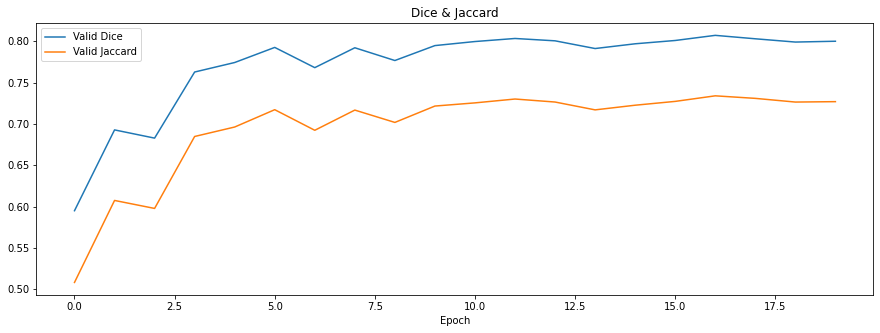

In [27]:
# Creating a plot to check dice and jaccard loss for training
plt.figure(figsize=(15,5))
plt.plot(range(Config.epochs),history['Valid Dice'],label='Valid Dice')
plt.plot(range(Config.epochs),history['Valid Jaccard'],label='Valid Jaccard')
plt.title('Dice & Jaccard'); plt.xlabel('Epoch'); plt.ylabel('');plt.legend(); 
plt.show()

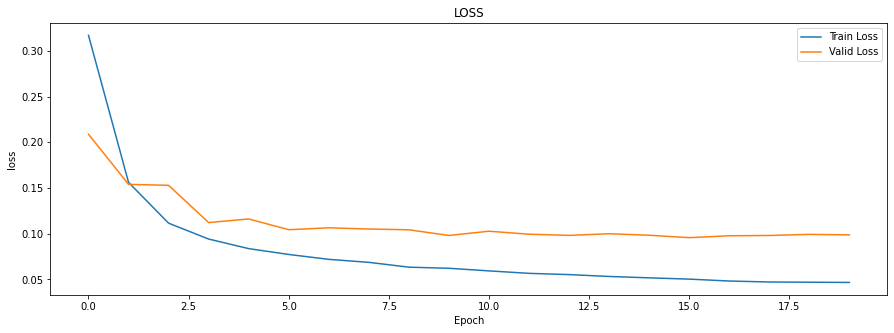

In [28]:
# Creating plots for train and validation dataset
plt.figure(figsize=(15,5))
plt.plot(range(Config.epochs),history['Train Loss'],label='Train Loss')
plt.plot(range(Config.epochs),history['Valid Loss'],label='Valid Loss')
plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend(); 
plt.show()

#### Generating Predictions

In [29]:
test_dataset = BuildDataset(df_train[df_train.index.isin(valid_ids)], 
                            transforms=data_transforms['valid'])
test_loader  = DataLoader(test_dataset, batch_size=5, 
                          num_workers=4, shuffle=False, pin_memory=True)

imgs, msks =  next(iter(test_loader))

imgs = imgs.to(Config.device, dtype=torch.float)

preds = []
for fold in range(1):
    model = load_model(f"best_epoch-{fold:02d}.bin")
    with torch.no_grad():
        pred = model(imgs)
        pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)
    
imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

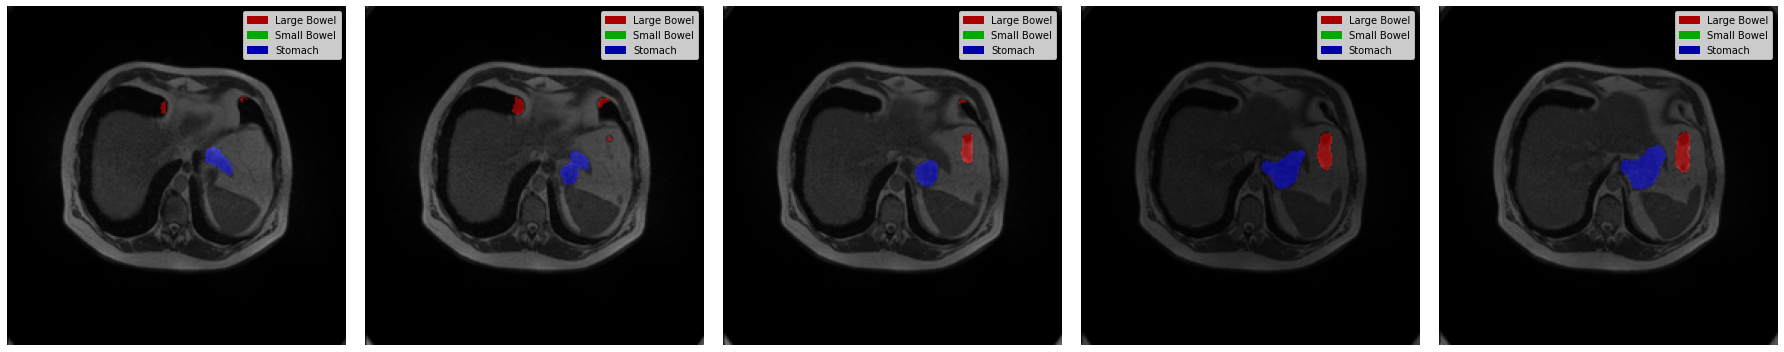

In [30]:
plot_batch(imgs, preds, size=5)

#### Computing class wise Dice and Jaccard Score

In [31]:
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ["Large Bowel", "Small Bowel", "Stomach"]) -> np.ndarray:
    """
    Calculate Dice score for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with dice scores for each class.
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)
                
    return scores


def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
               truth: np.ndarray,
               treshold: float = 0.5,
               eps: float = 1e-9,
               classes: list = ["Large Bowel", "Small Bowel", "Stomach"]) -> np.ndarray:
    """
    Calculate Jaccard index for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with jaccard scores for each class."
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

In [32]:
def compute_scores_per_classes(model,
                               dataloader,
                               classes):
    """Params:
        model: neural net for make predictions.
        dataloader: dataset object to load data from.
        classes: list with classes.
        Returns: dictionaries with dice and jaccard coefficients for each class for each slice.
    """

    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            imgs, targets = data[0], data[1]
            imgs, targets = imgs.to(Config.device), targets.to(Config.device)
            logits = model(imgs)
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            
            dice_scores = dice_coef_metric_per_classes(logits, targets)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets)

            
            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])
                
    return dice_scores_per_classes, iou_scores_per_classes

In [33]:
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(
    model, test_loader, ["Large Bowel", "Small Bowel", "Stomach"]
    )

In [34]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['Large Bowel Dice', 'Small Bowel Dice', 'Stomach Dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['Large Bowel Jaccard', 'Small Bowel Jaccard', 'Stomach Jaccard']
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['Large Bowel Dice', 'Large Bowel Jaccard', 
                                      'Small Bowel Dice', 'Small Bowel Jaccard', 
                                      'Stomach Dice', 'Stomach Jaccard']]
val_metics_df.head(3)

,Large Bowel Dice,Large Bowel Jaccard,Small Bowel Dice,Small Bowel Jaccard,Stomach Dice,Stomach Jaccard
0,4.545455e-11,4.545455e-11,1.0,1.0,3.636364e-12,3.636364e-12
1,1.020408e-11,1.020408e-11,1.0,1.0,4.897959e-01,3.243243e-01
2,8.745520e-01,7.770701e-01,1.0,1.0,7.099237e-01,5.502959e-01


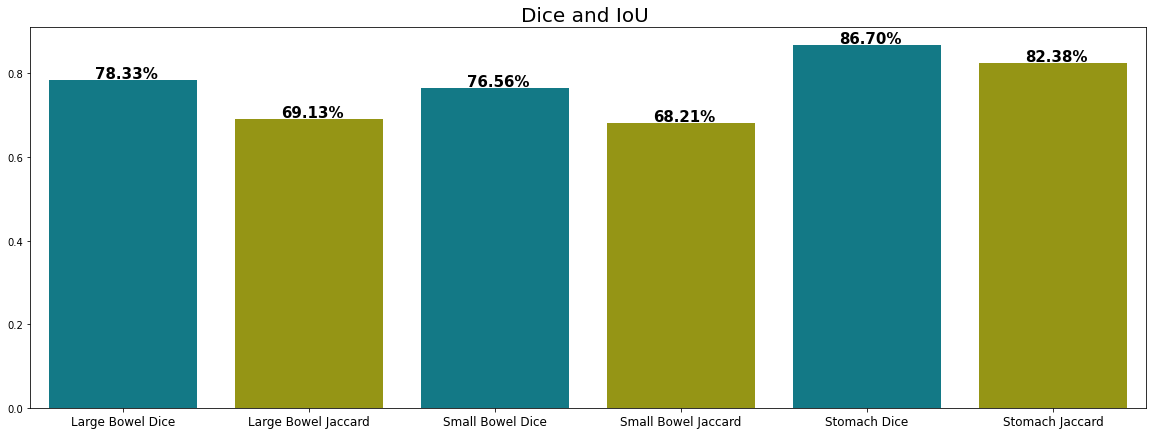

In [35]:
colors = ['#008899', '#aaaa00', '#008899', '#aaaa00', '#008899', '#aaaa00']
palette = sns.color_palette(colors, 6)

fig, ax = plt.subplots(figsize=(20, 7));
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax);
ax.set_xticklabels(val_metics_df.columns, fontsize=12, rotation=0);
ax.set_title("Dice and IoU ", fontsize=20)

for idx, p in enumerate(ax.patches):
        percentage = '{:.2f}%'.format(100 * val_metics_df.mean().values[idx])
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height() + 0.005
        ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")
